In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import datetime
from sklearn.preprocessing import LabelEncoder
import gc

import sklearn
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from tqdm.notebook import tqdm

#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
!python --version

Pandas : 1.0.1
Numpy : 1.18.1
Scikit-Learn : 0.22.1
Python 3.7.6


### data

In [3]:
#데이터로드
path = './data/'
data = pd.read_csv(path +'201901-202003.csv')
submission = pd.read_csv(path + 'submission.csv')

In [4]:
data.shape, submission.shape

((24697792, 12), (1394, 5))

### 전처리

#### 날짜변환

In [5]:
data['year'] = data['REG_YYMM'].apply(lambda x : int(str(x)[:4]))
data['month'] = data['REG_YYMM'].apply(lambda x : int(str(x)[4:]))
data.drop(['REG_YYMM'],axis= 1,inplace = True)

In [6]:
data.drop(['CARD_CCG_NM','HOM_CCG_NM'],axis= 1,inplace = True)

### 추가변수
* 추가변수 결합시 7월의 경우 4월의 것으로 대체해야하나??? (현재 4월데이터 없음)

#### 18 사업체총조사

In [7]:
all_jobs_df = pd.read_csv('./data/외부데이터/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [8]:
    sample = data[data.year == 2019]
    pivoted = sample.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns ='month',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

In [9]:
pivoted

month,CARD_SIDO_NM,STD_CLSS_NM,1,2,3,4,5,6,7,8,9,10,11,12
0,강원,건강보조식품 소매업,1.483547e+08,1.467159e+08,1.094390e+08,1.065485e+08,1.481157e+08,9.796009e+07,9.250573e+07,9.902312e+07,2.053536e+08,1.159177e+08,9.808464e+07,9.523231e+07
1,강원,골프장 운영업,1.229200e+09,1.152241e+09,2.760497e+09,3.964893e+09,5.493932e+09,5.663770e+09,5.032904e+09,5.800083e+09,4.158458e+09,5.652093e+09,4.017470e+09,1.239989e+09
2,강원,과실 및 채소 소매업,1.286979e+09,1.116266e+09,9.392280e+08,8.276834e+08,1.021473e+09,1.001626e+09,9.533469e+08,1.384944e+09,1.313429e+09,1.317877e+09,1.052642e+09,1.021407e+09
3,강원,관광 민예품 및 선물용품 소매업,3.065677e+07,2.292115e+07,2.502319e+07,1.790561e+07,4.058234e+07,3.079764e+07,2.920380e+07,5.839730e+07,2.788337e+07,5.313822e+07,3.094007e+07,2.991720e+07
4,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.770000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,충북,피자 햄버거 샌드위치 및 유사 음식점업,1.419836e+09,1.315558e+09,1.441132e+09,1.428269e+09,1.562180e+09,1.539625e+09,1.579520e+09,1.569194e+09,1.470381e+09,1.415832e+09,1.272053e+09,1.426056e+09
645,충북,한식 음식점업,2.159803e+10,1.949968e+10,2.295248e+10,2.216287e+10,2.443094e+10,2.313059e+10,2.353598e+10,2.461278e+10,2.193354e+10,2.293257e+10,2.143430e+10,2.389698e+10
646,충북,호텔업,3.466272e+07,3.395935e+07,3.603001e+07,4.051093e+07,4.440809e+07,3.458097e+07,2.586850e+07,2.957544e+07,3.446571e+07,3.347145e+07,5.389774e+07,6.138812e+07
647,충북,화장품 및 방향제 소매업,7.287220e+08,6.552886e+08,7.293284e+08,6.872543e+08,7.134974e+08,6.526526e+08,5.994955e+08,5.738562e+08,5.690937e+08,6.085027e+08,5.801607e+08,5.888324e+08


In [10]:
def local_percent(data):
    sample = data[data.year == 2019]
    pivoted = sample.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns ='month',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sum_arr = sample_sido.iloc[:,2:].sum().values.reshape(1,-1)
        parcent_df = (sample_sido.iloc[:,2:]/sum_arr)*100

        fin = pd.concat([sample_sido.iloc[:,:2],parcent_df],axis=1)
        local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='LP')
    local_percent_df['month'] = local_percent_df['month'].astype(int)
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [11]:
def job_percent(data):
    sample = data[data.year == 2019]
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns ='month',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = sample.pivot_table(index = ['STD_CLSS_NM'],columns ='month',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,2:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:2]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='JP')
    job_percent_df['month'] = job_percent_df['month'].astype(int)
    return job_percent_df

In [12]:
def local_rate(data):
    sample = data[data.year == 2019]
    sample.loc[sample.CARD_SIDO_NM == sample.HOM_SIDO_NM,'AMT_local'] = 1
    sample.loc[sample.CARD_SIDO_NM != sample.HOM_SIDO_NM,'AMT_local'] = 0
    local_rate_df = sample.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM','month'],columns = 'AMT_local',values = 'AMT',aggfunc = 'sum',fill_value= 0).reset_index()
    local_rate_df['local_AMT'] = local_rate_df[1.0]/(local_rate_df[0.0] +local_rate_df[1.0]) *100
    
    local_rate_df.drop([0.0,1.0],axis=1, inplace= True)
    
    return local_rate_df

In [13]:
local_rate_df = local_rate(data)
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)

C:\Users\kwonJH\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\kwonJH\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### 추가변수 결합

In [14]:
data.shape

(24697792, 11)

In [15]:
grouped = pd.merge(data,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
grouped = pd.merge(grouped,local_percent_df,on =['CARD_SIDO_NM','STD_CLSS_NM','month'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','STD_CLSS_NM','month'],how = 'left')
grouped = pd.merge(grouped,local_rate_df,on =['CARD_SIDO_NM','STD_CLSS_NM','month'],how = 'left')

In [16]:
grouped.shape

(24697792, 16)

In [17]:
grouped.head()

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month,company,employee,LP,JP,local_AMT
0,강원,건강보조식품 소매업,강원,20s,1,1,4,311200,4,2019,1,263.0,399.0,0.139214,3.874034,99.647467
1,강원,건강보조식품 소매업,강원,30s,1,2,7,1374500,8,2019,1,263.0,399.0,0.139214,3.874034,99.647467
2,강원,건강보조식품 소매업,강원,30s,2,2,6,818700,6,2019,1,263.0,399.0,0.139214,3.874034,99.647467
3,강원,건강보조식품 소매업,강원,40s,1,3,4,1717000,5,2019,1,263.0,399.0,0.139214,3.874034,99.647467
4,강원,건강보조식품 소매업,강원,40s,1,4,3,1047300,3,2019,1,263.0,399.0,0.139214,3.874034,99.647467


### 인코딩

#### 용량변환

In [18]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [19]:
#인코딩
def encoding(data):
    dtypes = grouped.dtypes
    encoders = {}
    for column in grouped.columns:
        if str(dtypes[column]) == 'object':
            encoder = LabelEncoder()
            encoder.fit(grouped[column])
            encoders[column] = encoder
    for column in encoders.keys():
        encoder = encoders[column]
        grouped[column] = encoder.transform(grouped[column])
    return encoders, data

In [20]:
encoders, grouped = encoding(grouped)

In [21]:
#메모리관리
grouped = reduce_mem_usage(grouped)

# del data
gc.collect()

Mem. usage decreased to 1059.91 Mb (62.5% reduction)


60

### Model Tuning & Evaluation

In [22]:
#2019.12까지 데이터로 20.03을 예측
train_set = grouped[grouped.year == 2019]
eval_set = grouped[(grouped.year == 2020)&(grouped.month == 3)]

In [23]:
params = {'random_state': 42,
          'learning_rate': 0.01,
          'max_depth': 8,
          'num_leaves': 64,
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7}

In [24]:
#세민님 파라미터
params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'metric': 'rmse',
    'tweedie_variance_power':1.1,
    'max_depth':11,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [25]:
#eval, train 구성
# train_x = train_set.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
# train_y = np.log1p(train_set['AMT'])

# eval_x = eval_set.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
# eval_y = np.log1p(eval_set['AMT'])

use_col = ['CARD_SIDO_NM','STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 
           'LP', 'JP','company','employee','local_AMT']
categorical_features = ['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM','SEX_CTGO_CD','AGE','FLC']

train_ds = lgb.Dataset(train_set[use_col],
                       label=np.log1p(train_set['AMT']),
                       free_raw_data=False,
                       categorical_feature=categorical_features)
eval_ds = lgb.Dataset(eval_set[use_col],
                      label=np.log1p(eval_set['AMT']),
                      free_raw_data=False,
                      categorical_feature=categorical_features)

In [26]:
evaluation_results ={}
model = lgb.train(params,train_ds,
                  num_boost_round=5000,
                  valid_sets=[train_ds, eval_ds],
                  valid_names=['Train', 'Eval'],
                  verbose_eval=500,
                  early_stopping_rounds=100, evals_result = evaluation_results)

C:\Users\kwonJH\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[500]	Train's rmse: 1.34451	Eval's rmse: 1.40774
[1000]	Train's rmse: 1.33261	Eval's rmse: 1.40196
[1500]	Train's rmse: 1.32873	Eval's rmse: 1.40039
[2000]	Train's rmse: 1.32662	Eval's rmse: 1.39986
[2500]	Train's rmse: 1.32522	Eval's rmse: 1.39942
[3000]	Train's rmse: 1.32424	Eval's rmse: 1.39902
[3500]	Train's rmse: 1.32349	Eval's rmse: 1.39883
Early stopping, best iteration is:
[3443]	Train's rmse: 1.32357	Eval's rmse: 1.39881


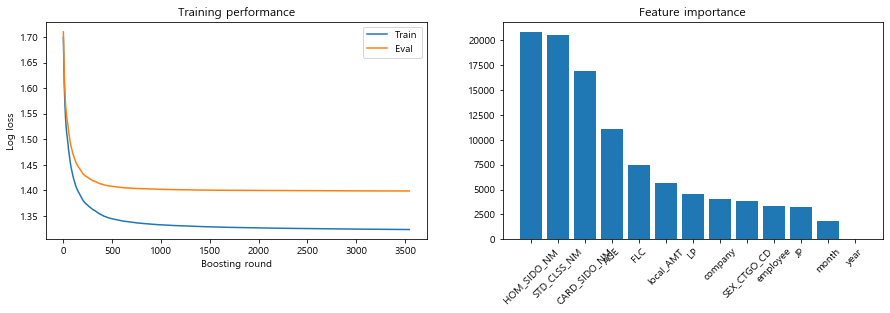

In [27]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['rmse'], label='Train')
axs[0].plot(evaluation_results['Eval']['rmse'], label='Eval')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': model.feature_name(), 
                            'importance': model.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'],rotation=45)
axs[1].set_title('Feature importance')

plt.show()

In [28]:
grouped.head(3)

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month,company,employee,LP,JP,local_AMT
0,0,0,0,1,1,1,4,311200,4,2019,1,263.0,399.0,0.13916,3.875,99.625
1,0,0,0,2,1,2,7,1374500,8,2019,1,263.0,399.0,0.13916,3.875,99.625
2,0,0,0,2,2,2,6,818700,6,2019,1,263.0,399.0,0.13916,3.875,99.625


#### 예측탬플릿만들기
* 추후 FLC손보기

In [29]:
#new(예측탬플릿), 4월 7월 나눠서 진행
def make_temp(grouped, train = True):
    CARD_SIDO_NMs = grouped['CARD_SIDO_NM'].unique()
    STD_CLSS_NMs = grouped['STD_CLSS_NM'].unique()
    HOM_SIDO_NMs = grouped['HOM_SIDO_NM'].unique()
    AGEs = grouped['AGE'].unique()
    SEX_CTGO_CDs = grouped['SEX_CTGO_CD'].unique()
    FLCs = grouped['FLC'].unique()
    years = [2020]
    if train == True :
        months = [3]
    else :
        months = [4,7]

    temp = []
    for CARD_SIDO_NM in tqdm(CARD_SIDO_NMs):
        for STD_CLSS_NM in STD_CLSS_NMs:
            for HOM_SIDO_NM in HOM_SIDO_NMs:
                for AGE in AGEs:
                    for SEX_CTGO_CD in SEX_CTGO_CDs:
                        for FLC in FLCs:
                            for year in years:
                                for month in months:
                                    temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
    temp = np.array(temp)
    temp = pd.DataFrame(data=temp, columns = ['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM','AGE','SEX_CTGO_CD','FLC','year','month'])
    
    #추가변수 삽입
    #변수삽입을 위한 디코더
    temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
    temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])
    temp['REG_YYMM'] = temp['year']*100 +temp['month']

    temp = pd.merge(temp,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
    temp = pd.merge(temp,local_percent_df,on =['CARD_SIDO_NM','STD_CLSS_NM','month'],how = 'left')
    temp = pd.merge(temp,job_percent_df,on =['CARD_SIDO_NM','STD_CLSS_NM','month'],how = 'left')

    temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].transform(temp['CARD_SIDO_NM'])
    temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].transform(temp['STD_CLSS_NM'])
    
    return temp

In [30]:
 temp = make_temp(grouped, train = True)

#### predict

In [31]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

### 예측결과 담기

In [33]:
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['AMT'] = np.round(pred,0)
temp['REG_YYMM'] = temp['year']*100 +temp['month']

temp = temp[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
temp = temp.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

In [34]:
#비교군
eval_set['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(eval_set['CARD_SIDO_NM'])
eval_set['REG_YYMM'] = eval_set['year'].astype('int64')*100 +eval_set['month']

eval_set = eval_set[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
eval_set = eval_set.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
eval_set.columns = ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT_answer']
temp = pd.merge(temp,eval_set,how = 'left')
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])
temp

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,AMT_answer
0,202003,강원,건강보조식품 소매업,373019162.0,9.605901e+07
1,202003,강원,골프장 운영업,236671712.0,2.915798e+09
2,202003,강원,과실 및 채소 소매업,199838017.0,9.948169e+08
3,202003,강원,관광 민예품 및 선물용품 소매업,146508249.0,1.331730e+07
4,202003,강원,그외 기타 분류안된 오락관련 서비스업,138594538.0,NaN
...,...,...,...,...,...
692,202003,충북,피자 햄버거 샌드위치 및 유사 음식점업,91380563.0,1.315245e+09
693,202003,충북,한식 음식점업,127882515.0,1.615248e+10
694,202003,충북,호텔업,293680659.0,1.524855e+07
695,202003,충북,화장품 및 방향제 소매업,307498255.0,4.288814e+08


In [41]:
#강원 정기 항공 운송업,면세점은 데이터로 보유하고 있지 않음. 근데 높게 예측 
#3다른 날에는 매출이 있으나, 2020년 3월에 데이터가 없는 경우 검증이 어려움...
no_nan = temp.loc[~(temp.AMT_answer.isna())]
# temp.loc[temp.AMT_answer.isna()].to_csv('./insight/없는없종na로라도 넣어봄.csv')

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
mean_squared_error(no_nan.AMT_answer,no_nan.AMT)

3.0315127145671675e+20

In [37]:
#제출파일과 비교
check_df = pd.merge(temp,all_jobs_df,left_on=['CARD_SIDO_NM','STD_CLSS_NM'],right_on=['CARD_SIDO_NM','STD_CLSS_NM'],how='left')

In [38]:
check_df[check_df.company.isna()]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,AMT_answer,company,employee
137,202003,경북,면세점,7.229009e+08,NaN,NaN,NaN
176,202003,광주,내항 여객 운송업,1.609587e+08,NaN,NaN,NaN
178,202003,광주,면세점,7.998140e+08,NaN,NaN,NaN
204,202003,광주,휴양콘도 운영업,4.395430e+08,NaN,NaN,NaN
217,202003,대구,내항 여객 운송업,2.293863e+08,NaN,NaN,NaN
245,202003,대구,휴양콘도 운영업,4.470283e+08,NaN,NaN,NaN
258,202003,대전,내항 여객 운송업,2.234329e+08,NaN,NaN,NaN
377,202003,세종,기타 수상오락 서비스업,4.167096e+08,NaN,NaN,NaN
381,202003,세종,내항 여객 운송업,3.043077e+08,NaN,NaN,NaN
383,202003,세종,면세점,2.049113e+09,NaN,NaN,NaN


In [39]:
del pred, train_set, eval_set

gc.collect()

191

### predict

In [ ]:
#train to private (4월예측모델)
#20년 1월까지 데이터만 사용
p_train = pd.concat([grouped[grouped.year == 2019],grouped[(grouped.year == 2020)&(grouped.month == 1)]])

In [ ]:
# Feature, taget 설정
# train_features = p_train.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
train_target = np.log1p(p_train['AMT'])

In [ ]:
train_ds = lgb.Dataset(p_train[use_col],label=train_target)
model = lgb.train(params,train_ds,num_boost_round=1000)

In [ ]:
del p_train

In [ ]:
grouped

In [ ]:
#new(예측탬플릿)
addresses = grouped['address'].unique()
STD_CLSS_NMs = grouped['STD_CLSS_NM'].unique()
HOM_SIDO_NMs = grouped['HOM_SIDO_NM'].unique()
AGEs = grouped['AGE'].unique()
SEX_CTGO_CDs = grouped['SEX_CTGO_CD'].unique()
FLCs = grouped['FLC'].unique()
years = [2020]
months = [4,7 ]

temp = []
for address in tqdm(addresses):
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([address, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns = ['address','STD_CLSS_NM','HOM_SIDO_NM','AGE','SEX_CTGO_CD','FLC','year','month'])

#### 추가변수준비

In [ ]:
temp

In [ ]:
#변수삽입을 위한 디코더
temp['address'] = encoders['address'].inverse_transform(temp['address'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

temp['CARD_SIDO_NM'] = temp['address'].apply(lambda x: x.split('_')[0])
temp['CARD_CCG_NM'] = temp['address'].apply(lambda x: x.split('_')[1])
temp['REG_YYMM'] = temp['year']*100 +temp['month']

temp = pd.merge(temp,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
temp = pd.merge(temp,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
temp = pd.merge(temp,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')

temp['address'] = encoders['address'].transform(temp['address'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].transform(temp['STD_CLSS_NM'])
temp.drop(['CARD_SIDO_NM','CARD_CCG_NM','REG_YYMM'],axis = 1,inplace = True)

In [ ]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

In [ ]:
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['AMT'] = np.round(pred,0)
temp['REG_YYMM'] = temp['year']*100 +temp['month']

temp = temp[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
temp = temp.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

#### 후처리

In [ ]:
#18년 사업체총조사 기준, 그 지역에 없는 업종은 0처리 
temp = pd.merge(temp,all_jobs_df,left_on=['CARD_SIDO_NM','STD_CLSS_NM'],right_on=['CARD_SIDO_NM','STD_CLSS_NM'],how='left')
temp.loc[temp.company.isna(),'AMT'] = 0

In [ ]:
#제출파일
submission = pd.read_csv('data/submission.csv',index_col=0)
submission = submission.drop(['AMT'],axis= 1)
submission = submission.merge(temp, left_on=['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],right_on =['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
submission.index.name = 'id'